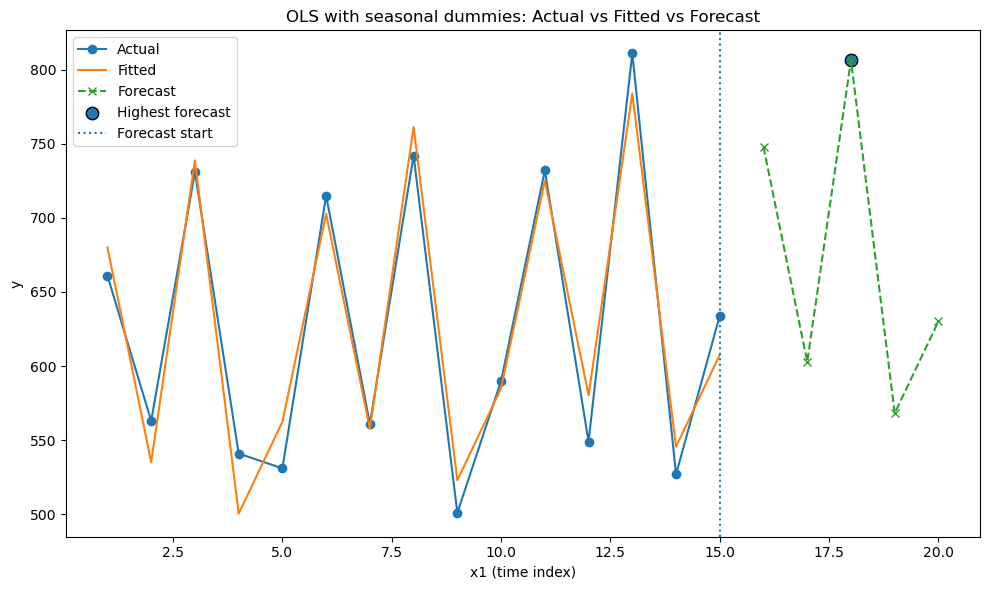


=== OLS – Coefficients ===
           coef  std_err        t   p>|t|    ci_low   ci_high
const  675.5467  20.1854  33.4670  0.0000  629.8840  721.2093
x1       4.5200   1.8478   2.4461  0.0370    0.3400    8.7000
x2    -149.5200  23.9266  -6.2491  0.0001 -203.6457  -95.3943
x3      49.6267  24.1397   2.0558  0.0700   -4.9811  104.2344
x4    -193.2267  24.4907  -7.8898  0.0000 -248.6286 -137.8248
x5    -135.7467  24.9739  -5.4355  0.0004 -192.2416  -79.2517

=== OLS – In-sample fitted & abs(error) ===
 x1    F_t  abs(error)
  1 680.07       19.07
  2 535.07       27.93
  3 738.73        7.73
  4 500.40       40.60
  5 562.40       31.40
  6 702.67       12.33
  7 557.67        3.33
  8 761.33       19.33
  9 523.00       22.00
 10 585.00        5.00
 11 725.27        6.73
 12 580.27       31.27
 13 783.93       27.07
 14 545.60       18.60
 15 607.60       26.40

OLS MAD: 19.92

=== OLS – Next forecasts (incl. % vs avg) ===
 x1  x2  x3  x4  x5  Forecast  PctDiffFromAvg
 16   0   0   0 

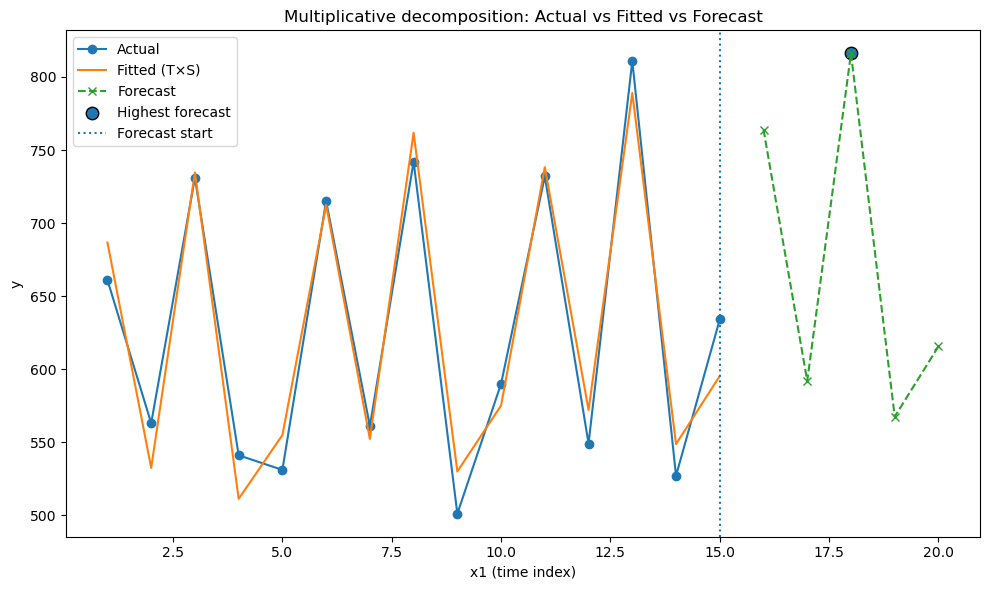


=== Multiplicative Decomposition – Seasonal indices (mean=1) ===
S1    1.1531
S2    0.8873
S3    1.2155
S4    0.8395
S5    0.9046

Multiplicative MAD: 20.02

=== Multiplicative Decomposition – Next forecasts (incl. % vs avg) ===
 x1  Trend_Forecast  Seasonal  Forecast  PctDiffFromAvg
 16          662.54      1.15    764.00           13.86
 17          667.01      0.89    591.86          -11.79
 18          671.49      1.22    816.18           21.64
 19          675.96      0.84    567.43          -15.43
 20          680.43      0.90    615.51           -8.27

Highest forecast (x1=18) is 21.64% above the 5-day forecast average.
The day with the highest value has 21.64% more value than an average day during the week.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ========= CONFIG =========
file_path = r"C:\Users\300393449\OneDrive - Douglas College\Documents\4th Semester\2_Business_Statistics_II\Python\DataScratch.xlsx"
sheet_name = "Seasonality"
forecast_horizon = 5  # next 5 rows (your "5-day forecast")

# ========= LOAD & CLEAN =========
def load_xy(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = [str(c).strip() for c in df.columns]
    if "y" not in df.columns:
        raise ValueError("Expected a column named 'y'.")

    # X = any column that starts with 'x' (case-insensitive). Ignore any 'Day' column.
    x_cols = [c for c in df.columns if c.lower().startswith("x")]
    if not x_cols:
        raise ValueError("No feature columns found (x1, x2, ...).")

    # Make numeric: convert '-' / blanks in X to 0; y must be numeric too
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    for c in x_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # Drop rows with missing y
    df = df.dropna(subset=["y"]).reset_index(drop=True)

    # Sort x* columns in numeric order (x1,x2,...,xN)
    def _x_key(c):
        try:
            return int(c[1:])
        except:
            return 10**9
    x_cols = sorted(x_cols, key=_x_key)

    return df, x_cols

# ========= (A) OLS with dummies: coefficients, MAD, forecast, plot =========
def fit_and_forecast_ols(df, x_cols, horizon=5):
    if "x1" not in x_cols:
        raise ValueError("Need an 'x1' column for the time index.")

    # OLS with intercept
    X = sm.add_constant(df[x_cols], has_constant="add")
    y = df["y"].values
    model = sm.OLS(y, X).fit()

    # In-sample fitted & MAD
    fitted = model.predict(X)
    abs_err = np.abs(y - fitted)
    mad = float(abs_err.mean())
    fitted_df = pd.DataFrame({"x1": df["x1"], "F_t": fitted, "abs(error)": abs_err})

    # Build next-horizon design matrix
    last_t = int(df["x1"].iloc[-1])

    # Rotate weekday/seasonal dummies: baseline (all zeros) -> each unit vector in order -> repeat
    day_cols = [c for c in x_cols if c != "x1"]
    states = [np.zeros(len(day_cols), dtype=int)]
    for i in range(len(day_cols)):
        v = np.zeros(len(day_cols), dtype=int)
        v[i] = 1
        states.append(v)

    # Identify last state (use baseline if not matched)
    last_vec = df[day_cols].iloc[-1].astype(int).to_numpy() if day_cols else np.array([], dtype=int)
    def state_index(vec):
        for k, s in enumerate(states):
            if np.array_equal(vec, s):
                return k
        return 0
    cur_idx = state_index(last_vec)

    # Create future rows
    future_rows = []
    for i in range(horizon):
        row = {"x1": last_t + 1 + i}
        next_idx = (cur_idx + 1 + i) % max(1, len(states))
        if day_cols:
            for j, c in enumerate(day_cols):
                row[c] = int(states[next_idx][j])
        future_rows.append(row)

    future_X = pd.DataFrame(future_rows, columns=x_cols)
    Xf = sm.add_constant(future_X, has_constant="add")
    y_fore = model.predict(Xf)

    forecast_df = future_X.copy()
    forecast_df["Forecast"] = y_fore

    # ---- % higher than the 5-day average ----
    avg5 = forecast_df["Forecast"].mean()
    forecast_df["PctDiffFromAvg"] = 100.0 * (forecast_df["Forecast"] - avg5) / avg5
    idx_top = int(forecast_df["Forecast"].idxmax())
    x1_top = int(forecast_df.loc[idx_top, "x1"])
    top_fore = float(forecast_df.loc[idx_top, "Forecast"])
    pct_more = 100.0 * (top_fore - avg5) / avg5

    # Coefficient table
    coef = model.params.rename("coef")
    se = model.bse.rename("std_err")
    tval = model.tvalues.rename("t")
    pval = model.pvalues.rename("p>|t|")
    ci = model.conf_int()
    ci.columns = ["ci_low", "ci_high"]
    coef_table = pd.concat([coef, se, tval, pval, ci], axis=1)

    # Plot: Actual vs Fitted vs Forecast (mark highest forecast)
    plt.figure(figsize=(10, 6))
    plt.plot(df["x1"], df["y"], marker='o', label='Actual')
    plt.plot(df["x1"], fitted, label='Fitted')
    plt.plot(forecast_df["x1"], forecast_df["Forecast"], marker='x', linestyle='--', label='Forecast')
    plt.scatter([x1_top], [top_fore], s=80, edgecolor='k', label='Highest forecast')
    plt.axvline(df["x1"].iloc[-1], linestyle=':', label='Forecast start')
    plt.xlabel("x1 (time index)")
    plt.ylabel("y")
    plt.title("OLS with seasonal dummies: Actual vs Fitted vs Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

    summary_text = f"Highest forecast (x1={x1_top}) is {pct_more:.2f}% above the 5-day forecast average."

    return model, coef_table, fitted_df, mad, forecast_df, summary_text

# ========= (B) Multiplicative decomposition forecast (Y = T * S * E) =========
def multiplicative_decomp_forecast(df, x_cols, horizon=5):
    if "x1" not in x_cols:
        raise ValueError("Need an 'x1' column for the time index.")
    y = df["y"].to_numpy(dtype=float)
    t = df["x1"].to_numpy(dtype=int)

    # Seasonal period from dummy columns: baseline (all zeros) + one-hot columns
    day_cols = [c for c in x_cols if c != "x1"]
    period = len(day_cols) + 1 if len(day_cols) > 0 else 1

    # Map each row to season position s ∈ {1..period}
    if day_cols:
        D = df[day_cols].astype(int).to_numpy()
        season_pos = []
        for row in D:
            if row.sum() == 0:
                season_pos.append(1)
            else:
                j = int(np.argmax(row))
                season_pos.append(j + 2)  # 1=baseline, x2->2, x3->3, ...
    else:
        season_pos = (((t - 1) % period) + 1).tolist()

    # Centered moving average (CMA)
    s_series = pd.Series(y)
    cma = s_series.rolling(window=period, center=True).mean().to_numpy()

    # Ratio to moving average
    rma = np.divide(y, cma, out=np.full_like(y, np.nan), where=~np.isnan(cma))

    # Seasonal factors by position
    sf = np.empty(period, dtype=float)
    for s in range(1, period + 1):
        vals = [rma[i] for i in range(len(rma)) if season_pos[i] == s and not np.isnan(rma[i])]
        sf[s - 1] = np.nan if len(vals) == 0 else np.nanmean(vals)
    if np.isnan(sf).all():
        sf[:] = 1.0
    else:
        fill_val = np.nanmean(sf[~np.isnan(sf)])
        sf = np.where(np.isnan(sf), fill_val, sf)
    sf = sf / sf.mean()

    # Assign seasonal factor
    seasonal = np.array([sf[s - 1] for s in season_pos], dtype=float)

    # Deseasonalize and fit linear trend
    deseason = y / seasonal
    trend_model = LinearRegression().fit(t.reshape(-1, 1), deseason)

    # Fitted values and MAD (re-seasonalized)
    trend_fitted = trend_model.predict(t.reshape(-1, 1))
    fitted_mult = trend_fitted * seasonal
    mad = float(np.mean(np.abs(y - fitted_mult)))

    # Forecast future t and season positions
    t_future = np.arange(t[-1] + 1, t[-1] + 1 + horizon)
    next_start_pos = (season_pos[-1] % period) + 1
    future_pos = [((next_start_pos - 1 + i) % period) + 1 for i in range(horizon)]
    seasonal_future = np.array([sf[s - 1] for s in future_pos], dtype=float)

    trend_fore = trend_model.predict(t_future.reshape(-1, 1))
    y_fore = trend_fore * seasonal_future

    forecast_df = pd.DataFrame({
        "x1": t_future,
        "Trend_Forecast": trend_fore,
        "Seasonal": seasonal_future,
        "Forecast": y_fore
    })

    # ---- % higher than the 5-day average ----
    avg5 = forecast_df["Forecast"].mean()
    forecast_df["PctDiffFromAvg"] = 100.0 * (forecast_df["Forecast"] - avg5) / avg5
    idx_top = int(forecast_df["Forecast"].idxmax())
    x1_top = int(forecast_df.loc[idx_top, "x1"])
    top_fore = float(forecast_df.loc[idx_top, "Forecast"])
    pct_more = 100.0 * (top_fore - avg5) / avg5

    # Plot: Actual vs Fitted vs Forecast (mark highest forecast)
    plt.figure(figsize=(10, 6))
    plt.plot(t, y, marker='o', label='Actual')
    plt.plot(t, fitted_mult, label='Fitted (T×S)')
    plt.plot(forecast_df["x1"], forecast_df["Forecast"], marker='x', linestyle='--', label='Forecast')
    plt.scatter([x1_top], [top_fore], s=80, edgecolor='k', label='Highest forecast')
    plt.axvline(t[-1], linestyle=':', label='Forecast start')
    plt.xlabel("x1 (time index)")
    plt.ylabel("y")
    plt.title("Multiplicative decomposition: Actual vs Fitted vs Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

    seasonal_indices = pd.Series(sf, index=[f"S{s}" for s in range(1, period + 1)])
    summary_text = f"Highest forecast (x1={x1_top}) is {pct_more:.2f}% above the 5-day forecast average."

    return forecast_df, mad, seasonal_indices, summary_text

def highest_vs_avg_sentence(df, value_col="Forecast", digits=2):
    avg = df[value_col].mean()
    pct = 100.0 * (df[value_col].max() - avg) / avg
    return f"The day with the highest value has {pct:.{digits}f}% more value than an average day during the week."


# ========= RUN =========
df, Xcols = load_xy(file_path, sheet_name)

# (A) OLS path
model, coef_table, fitted_err_df, MAD_ols, next_forecast_ols, summary_ols = fit_and_forecast_ols(df, Xcols, forecast_horizon)
print("\n=== OLS – Coefficients ===")
print(coef_table.round(4).to_string())
print("\n=== OLS – In-sample fitted & abs(error) ===")
print(fitted_err_df.round(2).to_string(index=False))
print(f"\nOLS MAD: {MAD_ols:.2f}")
print("\n=== OLS – Next forecasts (incl. % vs avg) ===")
print(next_forecast_ols.round(2).to_string(index=False))
print("\n" + summary_ols)
print(highest_vs_avg_sentence(next_forecast_ols))

# (B) Multiplicative decomposition path
forecast_mult, MAD_mult, seasonal_idx, summary_mult = multiplicative_decomp_forecast(df, Xcols, forecast_horizon)
print("\n=== Multiplicative Decomposition – Seasonal indices (mean=1) ===")
print(seasonal_idx.round(4).to_string())
print(f"\nMultiplicative MAD: {MAD_mult:.2f}")
print("\n=== Multiplicative Decomposition – Next forecasts (incl. % vs avg) ===")
print(forecast_mult.round(2).to_string(index=False))
print("\n" + summary_mult)
print(highest_vs_avg_sentence(forecast_mult))


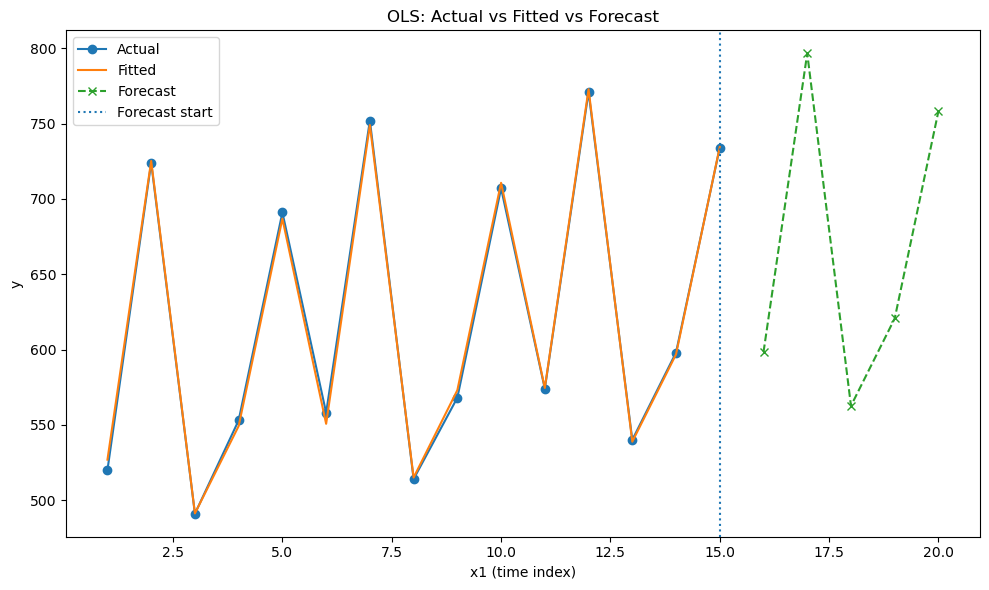


=== Regression (OLS) – coefficients ===
           coef  std_err         t   p>|t|    ci_low   ci_high
const  522.1067   3.1655  164.9359  0.0000  514.9458  529.2676
x1       4.7600   0.2898   16.4265  0.0000    4.1045    5.4155
x2     193.5733   3.7522   51.5892  0.0000  185.0853  202.0614
x3     -45.1867   3.7856  -11.9364  0.0000  -53.7503  -36.6230
x4       8.0533   3.8407    2.0969  0.0655   -0.6349   16.7415
x5     140.9600   3.9165   35.9918  0.0000  132.1004  149.8196

=== In-sample fitted values & absolute errors ===
   F_t  abs(error)
526.87        6.87
725.20        1.20
491.20        0.20
549.20        3.80
686.87        4.13
550.67        7.33
749.00        3.00
515.00        1.00
573.00        5.00
710.67        3.67
574.47        0.47
772.80        1.80
538.80        1.20
596.80        1.20
734.47        0.47

MAD: 2.76

=== Next forecasts ===
 x1  x2  x3  x4  x5  Forecast
 16   0   0   0   0    598.27
 17   1   0   0   0    796.60
 18   0   1   0   0    562.60
 19   0 

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ========= CONFIG =========
file_path = r"C:\Users\PCAdmin\OneDrive - Douglas College\Documents\4th Semester\2_Business_Statistics_II\Python\DataScratch.xlsx"
sheet_name = "Seasonality"
forecast_horizon = 5  # next 5 rows (e.g., a week)

# ========= LOAD & CLEAN =========
def load_xy(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet)
    df.columns = [str(c).strip() for c in df.columns]

    if "y" not in df.columns:
        raise ValueError("Expected a column named 'y' in the sheet.")

    # X = any column that starts with 'x' (case-insensitive). Ignore any 'Day' column entirely.
    x_cols = [c for c in df.columns if c.lower().startswith("x")]
    if not x_cols:
        raise ValueError("No feature columns found. Expecting columns named x1, x2, ...")

    # Make numeric: convert '-'/blanks in X to 0; y must be numeric too
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    for c in x_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # Drop rows with missing y
    df = df.dropna(subset=["y"]).reset_index(drop=True)
    return df, x_cols

# ========= FIT, DIAGNOSTICS, FORECAST, PLOT =========
def fit_and_forecast(df, x_cols, horizon=5):
    # OLS with intercept
    X = sm.add_constant(df[x_cols], has_constant="add")
    y = df["y"].values
    model = sm.OLS(y, X).fit()

    # In-sample fitted values and MAD
    fitted = model.predict(X)
    abs_err = np.abs(y - fitted)
    mad = float(abs_err.mean())
    fitted_df = pd.DataFrame({"F_t": fitted, "abs(error)": abs_err})

    # -------- Build next-horizon design matrix --------
    # Assume x1 is the linear time index
    if "x1" not in x_cols:
        raise ValueError("Need an 'x1' column for the time index.")
    last_t = int(df["x1"].iloc[-1])

    # Seasonal/weekday dummies are remaining x's (x2..xN).
    # Rotate through states: baseline (all zeros) -> unit vectors for each dummy in order -> repeat.
    day_cols = [c for c in x_cols if c != "x1"]
    states = [np.zeros(len(day_cols), dtype=int)]
    for i in range(len(day_cols)):
        v = np.zeros(len(day_cols), dtype=int)
        v[i] = 1
        states.append(v)

    # Index of the last observed state
    last_vec = df[day_cols].iloc[-1].astype(int).to_numpy() if day_cols else np.array([], dtype=int)

    def state_index(vec):
        for k, s in enumerate(states):
            if np.array_equal(vec, s):
                return k
        return 0  # fallback to baseline

    cur_idx = state_index(last_vec)

    # Create future rows
    future_rows = []
    for i in range(horizon):
        row = {"x1": last_t + 1 + i}
        next_idx = (cur_idx + 1 + i) % len(states) if len(states) > 0 else 0
        if day_cols:
            for j, c in enumerate(day_cols):
                row[c] = int(states[next_idx][j])
        future_rows.append(row)

    future_X = pd.DataFrame(future_rows, columns=x_cols)
    Xf = sm.add_constant(future_X, has_constant="add")
    y_fore = model.predict(Xf)

    forecast_df = future_X.copy()
    forecast_df["Forecast"] = y_fore

    # -------- Coefficient table (compact regression table) --------
    coef = model.params.rename("coef")
    se = model.bse.rename("std_err")
    tval = model.tvalues.rename("t")
    pval = model.pvalues.rename("p>|t|")
    ci = model.conf_int()
    ci.columns = ["ci_low", "ci_high"]
    coef_table = pd.concat([coef, se, tval, pval, ci], axis=1)

    # -------- Plot: Actual vs Fitted vs Forecast --------
    plt.figure(figsize=(10, 6))
    plt.plot(df["x1"], df["y"], marker='o', label='Actual')
    plt.plot(df["x1"], fitted, label='Fitted')
    plt.plot(forecast_df["x1"], forecast_df["Forecast"], marker='x', linestyle='--', label='Forecast')
    plt.axvline(df["x1"].iloc[-1], linestyle=':', label='Forecast start')
    plt.xlabel("x1 (time index)")
    plt.ylabel("y")
    plt.title("OLS: Actual vs Fitted vs Forecast")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, coef_table, fitted_df, mad, forecast_df

# ========= RUN =========
df, Xcols = load_xy(file_path, sheet_name)
model, coef_table, fitted_err_df, MAD, next_forecast = fit_and_forecast(df, Xcols, forecast_horizon)

# ---- Outputs ----
print("\n=== Regression (OLS) – coefficients ===")
print(coef_table.round(4).to_string())

print("\n=== In-sample fitted values & absolute errors ===")
print(fitted_err_df.round(2).to_string(index=False))

print(f"\nMAD: {MAD:.2f}")

print("\n=== Next forecasts ===")
print(next_forecast.round(2).to_string(index=False))
